<a href="https://colab.research.google.com/github/dalyhachicha/Breast-Cancer-Classification/blob/main/Breast_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import cv2

In [2]:
# Dataset path in colab
data = '/content/dataset/10264'
no_breast_cancer = '/content/dataset/10264/0'
yes_breast_cancer = '/content/dataset/10264/1'

In [3]:
# Reading dataset

from google.colab import files
dirlist=[no_breast_cancer, yes_breast_cancer]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  1204    labels:  1204


In [4]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(1204,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/dataset/10264/0/10264_idx5_x1601_y101...,No
1,/content/dataset/10264/0/10264_idx5_x2451_y110...,No
2,/content/dataset/10264/0/10264_idx5_x1701_y151...,No
3,/content/dataset/10264/0/10264_idx5_x2301_y851...,No
4,/content/dataset/10264/0/10264_idx5_x2351_y100...,No


In [5]:
# Count of NO/YES img labels
df['labels'].value_counts()

No     617
Yes    587
Name: labels, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


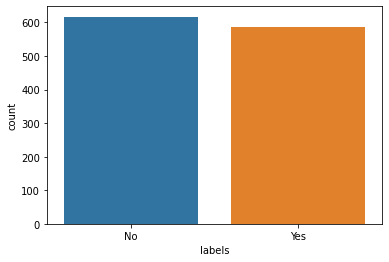

In [6]:
sns.countplot(df['labels'], label='count')

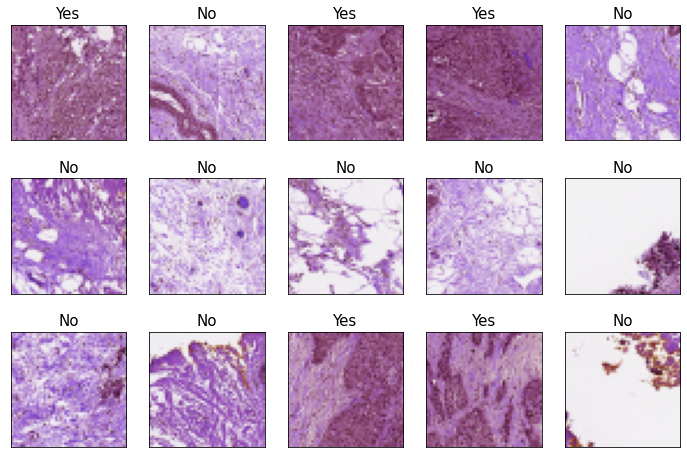

In [7]:
# Visualize Brain Images
import cv2

plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15,) 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.75, random_state=0)
train_new, valid = train_test_split(train, train_size=0.75, random_state=0)

print(f"Train dataset shape: {train_new.shape}")
print(f"Test dataset shape: {test.shape}")
print(f"Validation dataset shape: {valid.shape}")

Train dataset shape: (677, 2)
Test dataset shape: (301, 2)
Validation dataset shape: (226, 2)


In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 677 validated image filenames belonging to 2 classes.
Found 226 validated image filenames belonging to 2 classes.
Found 301 validated image filenames belonging to 2 classes.


In [17]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [12]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
) 

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable

In [15]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])

# Change epochs to 100
history = model.fit(train_gen, validation_data = val_gen, epochs = 10, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 0.7120 - accuracy: 0.5790

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


22/22 [==============================] - 162s 7s/step - loss: 0.7120 - accuracy: 0.5790 - val_loss: 0.6613 - val_accuracy: 0.5973
Epoch 2/10
22/22 [==============================] - 137s 6s/step - loss: 0.7264 - accuracy: 0.5643 - val_loss: 0.6365 - val_accuracy: 0.6327
Epoch 3/10
22/22 [==============================] - 135s 6s/step - loss: 0.6698 - accuracy: 0.6012 - val_loss: 0.6556 - val_accuracy: 0.6283
Epoch 4/10
22/22 [==============================] - 135s 6s/step - loss: 0.6353 - accuracy: 0.6411 - val_loss: 0.5991 - val_accuracy: 0.6814
Epoch 5/10
22/22 [==============================] - 136s 6s/step - loss: 0.6004 - accuracy: 0.6691 - val_loss: 0.5842 - val_accuracy: 0.6947
Epoch 6/10
22/22 [==============================] - 139s 6s/step - loss: 0.5768 - accuracy: 0.6913 - val_loss: 0.5303 - val_accuracy: 0.7522
Epoch 7/10
22/22 [==============================] - 135s 6s/step - loss: 0.5584 - accuracy: 0.7282 - val_loss: 0.5207 - val_accuracy: 0.7478
Epoch 8/10
22/22 [======

In [18]:
model.save("model.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# Model evaluation
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# Classify single image 
from PIL import Image
model_path = "model.h5"
loaded_model = tf.keras.models.load_model(model_path)

# import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/img_to_classify.png")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
if pred >= 0.5:
  print("Yes")
else:
  print("No")